In [12]:
import time
import numpy as np
import pandas as pd
import shap
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')


start_time = time.time()

df = pd.read_csv("GGS_new_renamed_features.csv", sep=',')
display(df)
df=shuffle(df, random_state=7)

df["Religiosity"] = (df["Religiosity"] + 1).fillna(0).astype('int32')
df["Generation_bin"] = df["Generations"].map({1:1, 2:1, 3:1, 4:1, 5:2, 6:2})
df = df.fillna("Data_missing")
#display(df)


features = ["Gender","Generation_bin","Generations","Education","Locality","Mobility","Partnership",
            "Marriage","Childs","Religiosity"]

acc_f = []
acc_s = []
acc   = []

models = [#["SVM     ", svm.SVC(probability=False, gamma='auto')],
          ["XGBoost ", XGBClassifier(n_estimators=500, learning_rate=0.01, verbosity=0)]]
          #["CatBoost", CatBoostClassifier(iterations=700, learning_rate=0.01, verbose=False)]]

print (100*"=")
print (models[0][0], "Accuracy\tby Features \tby Statuses \tTotal \t\tStatuses Improv Total Improv")
print (100*"=")
    
for feature in features:
    
    y = df[feature]
    Xf = df[features].drop(columns=feature).copy()
    
    if feature == "Generation_bin":
        Xf = Xf.drop(columns="Generations") # "Generations_bin is derivative from "Generations"
    if feature == "Generations":
        Xf = Xf.drop(columns="Generation_bin")
    #display(Xf)
    
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, y, test_size=0.2, random_state=42)

    
    Xs = df.drop(columns=["Gender", "Generation_bin", "Generations", "Education", "Locality",
                         "Mobility","Partnership", "Marriage","Childs","Religiosity", "Religion", 
                          "Church_visit", "sg", "sge","sgl", "generations2", "age"])

    X = Xf.merge(Xs, left_index=True, right_index=True)
    
    Xs = Xs.apply(LabelEncoder().fit_transform).copy()    
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
    
    X = X.apply(LabelEncoder().fit_transform).copy()    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    for model in models:
        
        model[1].fit(Xf_train, yf_train)
        yf_pred = model[1].predict(Xf_test)
        acc_f.append(accuracy_score(yf_test, yf_pred))
        
        model[1].fit(Xs_train, ys_train)
        ys_pred = model[1].predict(Xs_test)
        acc_s.append(accuracy_score(ys_test, ys_pred))
        
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        
        print(feature.ljust(12), "\t\t%.3f" % acc_f[-1], "\t\t%.3f" % acc_s[-1], "\t\t%.3f" % acc[-1], 
              "\t\t%5.1f" % ((acc_s[-1]-acc_f[-1])*100), "%", "\t%5.1f" % ((acc[-1]-acc_f[-1])*100), "%")
        print (100*"_")
        
print (100*"=")

for model in models:
    
    acc_f_mean = np.mean(acc_f)
    acc_s_mean = np.mean(acc_s)
    acc_mean   = np.mean(acc)
    
    print("\tAverage".ljust(12), "\t%.3f" % acc_f_mean, "\t\t%.3f" % acc_s_mean, "\t\t%.3f" % acc_mean, 
          "\t\t%5.1f" % ((acc_s_mean-acc_f_mean)*100/acc_f_mean), "%", 
          "\t%5.1f" % ((acc_mean-acc_f_mean)*100/acc_f_mean), "%")
    
print (100*"=")
print ("Time, s: ", "%.0f" % (time.time() - start_time))

,ID,Gender,Generations,Education,Locality,Mobility,Partnership,Marriage,Childs,Religiosity,...,a34.3,a34.4,a34.5,a34.6,a34.7,a34.8,a34.9,a34.10,a34.11,a34.12
0,1,2,5,3,2,1,0,1,2,1.0,...,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+
1,2,2,5,2,2,1,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,NaN,NaN
2,3,2,2,1,2,3,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E
3,4,1,5,2,2,1,3,0,1,1.0,...,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J
4,5,2,2,2,2,3,0,1,1,1.0,...,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5446,11270,2,6,1,1,1,1,0,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5447,11271,2,3,2,1,1,2,1,2,1.0,...,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L
5448,11275,2,4,3,1,3,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E
5449,11277,2,6,3,1,3,0,0,0,1.0,...,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+


XGBoost  Accuracy	by Features 	by Statuses 	Total 		Statuses Improv Total Improv
Gender       		0.676 		0.725 		0.739 		  4.9 % 	  6.2 %
____________________________________________________________________________________________________
Generation_bin 		0.775 		0.882 		0.877 		 10.6 % 	 10.2 %
____________________________________________________________________________________________________
Generations  		0.301 		0.398 		0.445 		  9.7 % 	 14.4 %
____________________________________________________________________________________________________
Education    		0.596 		0.700 		0.725 		 10.4 % 	 12.9 %
____________________________________________________________________________________________________
Locality     		0.543 		0.977 		0.973 		 43.4 % 	 43.1 %
____________________________________________________________________________________________________
Mobility     		0.697 		0.654 		0.695 		 -4.2 % 	 -0.2 %
____________________________________________________________________________

In [2]:
import time
import numpy as np
import pandas as pd
import shap
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')


start_time = time.time()

df = pd.read_csv("GGS_new_renamed_features.csv", sep=',')
display(df)
df=shuffle(df, random_state=7)

df["Religiosity"] = (df["Religiosity"] + 1).fillna(0).astype('int32')
df["Generation_bin"] = df["Generations"].map({1:1, 2:1, 3:1, 4:1, 5:2, 6:2})
df = df.fillna("Data_missing")


features = ["Gender","Generation_bin","Generations","Education","Locality","Mobility","Partnership",
            "Marriage","Childs","Religiosity"]

acc_f = []
acc_s = []
acc   = []

models = [#["SVM     ", svm.SVC(probability=False, gamma='auto')],
          #["XGBoost ", XGBClassifier(n_estimators=500, learning_rate=0.01, verbosity=0)]]
          ["CatBoost", CatBoostClassifier(iterations=700, learning_rate=0.01, verbose=False)]]

print (100*"=")
print (models[0][0], "Accuracy\tby Features \tby Statuses \tTotal \t\tStatuses Improv Total Improv")
print (100*"=")
    
for feature in features:
    
    y = df[feature]
    Xf = df[features].drop(columns=feature).copy()
    
    if feature == "Generation_bin":
        Xf = Xf.drop(columns="Generations") # "Generations_bin is derivative from "Generations"
    if feature == "Generations":
        Xf = Xf.drop(columns="Generation_bin")
    #display(Xf)
    
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, y, test_size=0.2, random_state=42)

    
    Xs = df.drop(columns=["Gender", "Generation_bin", "Generations", "Education", "Locality",
                         "Mobility","Partnership", "Marriage","Childs","Religiosity", "Religion", 
                          "Church_visit", "sg", "sge","sgl", "generations2", "age"])

    X = Xf.merge(Xs, left_index=True, right_index=True)
    
    Xs = Xs.apply(LabelEncoder().fit_transform).copy()    
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
    
    X = X.apply(LabelEncoder().fit_transform).copy()    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    for model in models:
        
        model[1].fit(Xf_train, yf_train)
        yf_pred = model[1].predict(Xf_test)
        acc_f.append(accuracy_score(yf_test, yf_pred))
        
        model[1].fit(Xs_train, ys_train)
        ys_pred = model[1].predict(Xs_test)
        acc_s.append(accuracy_score(ys_test, ys_pred))
        
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        acc.append(accuracy_score(y_test, y_pred))
        
        print(feature.ljust(12), "\t\t%.3f" % acc_f[-1], "\t\t%.3f" % acc_s[-1], "\t\t%.3f" % acc[-1], 
              "\t\t%5.1f" % ((acc_s[-1]-acc_f[-1])*100), "%", "\t%5.1f" % ((acc[-1]-acc_f[-1])*100), "%")
        print (100*"_")
        
print (100*"=")

for model in models:
    
    acc_f_mean = np.mean(acc_f)
    acc_s_mean = np.mean(acc_s)
    acc_mean   = np.mean(acc)
    
    print("\tAverage".ljust(12), "\t%.3f" % acc_f_mean, "\t\t%.3f" % acc_s_mean, "\t\t%.3f" % acc_mean, 
          "\t\t%5.1f" % ((acc_s_mean-acc_f_mean)*100/acc_f_mean), "%", 
          "\t%5.1f" % ((acc_mean-acc_f_mean)*100/acc_f_mean), "%")
    
print (100*"=")
print ("Time, s: ", "%.0f" % (time.time() - start_time))

,ID,Gender,Generations,Education,Locality,Mobility,Partnership,Marriage,Childs,Religiosity,...,a34.3,a34.4,a34.5,a34.6,a34.7,a34.8,a34.9,a34.10,a34.11,a34.12
0,1,2,5,3,2,1,0,1,2,1.0,...,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+
1,2,2,5,2,2,1,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,NaN,NaN
2,3,2,2,1,2,3,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E
3,4,1,5,2,2,1,3,0,1,1.0,...,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J
4,5,2,2,2,2,3,0,1,1,1.0,...,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5446,11270,2,6,1,1,1,1,0,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5447,11271,2,3,2,1,1,2,1,2,1.0,...,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L
5448,11275,2,4,3,1,3,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E
5449,11277,2,6,3,1,3,0,0,0,1.0,...,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+


CatBoost Accuracy	by Features 	by Statuses 	Total 		Statuses Improv Total Improv
Gender       		0.686 		0.712 		0.737 		  2.7 % 	  5.1 %
____________________________________________________________________________________________________
Generation_bin 		0.787 		0.875 		0.878 		  8.8 % 	  9.1 %
____________________________________________________________________________________________________
Generations  		0.320 		0.406 		0.449 		  8.6 % 	 12.9 %
____________________________________________________________________________________________________
Education    		0.624 		0.676 		0.689 		  5.2 % 	  6.5 %
____________________________________________________________________________________________________
Locality     		0.547 		0.739 		0.752 		 19.2 % 	 20.4 %
____________________________________________________________________________________________________
Mobility     		0.694 		0.634 		0.687 		 -6.0 % 	 -0.6 %
____________________________________________________________________________

,ID,Gender,Generations,Education,Locality,Mobility,Partnership,Marriage,Childs,Religiosity,...,a34.3,a34.4,a34.5,a34.6,a34.7,a34.8,a34.9,a34.10,a34.11,a34.12
0,1,2,5,3,2,1,0,1,2,1.0,...,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+,M1C1J+
1,2,2,5,2,2,1,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,NaN,NaN
2,3,2,2,1,2,3,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E
3,4,1,5,2,2,1,3,0,1,1.0,...,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J,SC1++J
4,5,2,2,2,2,3,0,1,1,1.0,...,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L,M1C1++L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5446,11270,2,6,1,1,1,1,0,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5447,11271,2,3,2,1,1,2,1,2,1.0,...,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L,P1C1++L
5448,11275,2,4,3,1,3,0,1,2,1.0,...,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E,M1C1++E
5449,11277,2,6,3,1,3,0,0,0,1.0,...,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+,SC0L+



Men:	 1758
Women:	 3693
Total:	 5451
================================ SHAP ==================================

		  Features impact on status prediction for Age=34


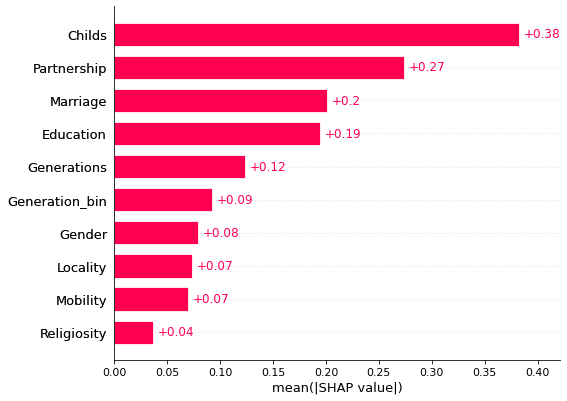

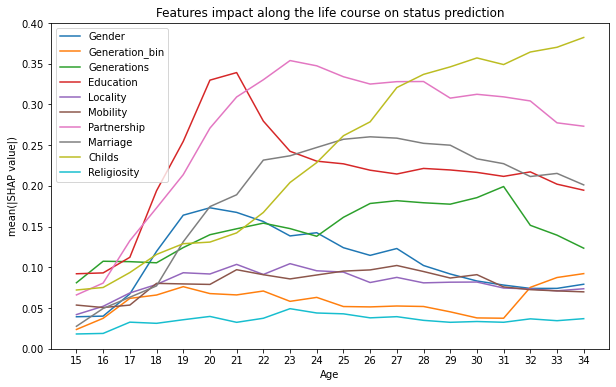

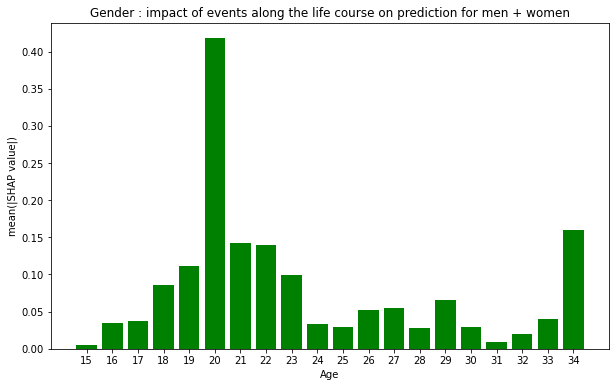

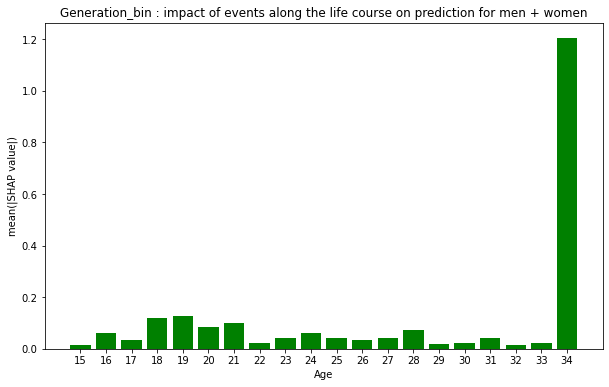

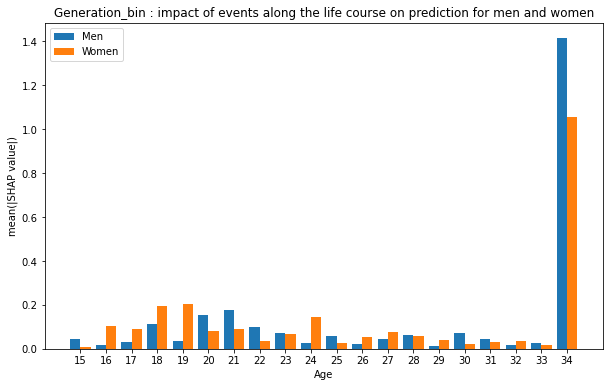

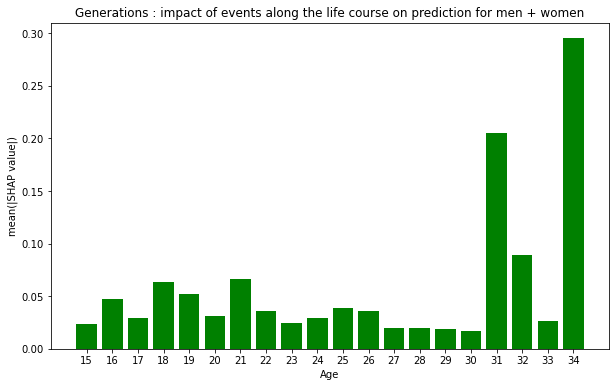

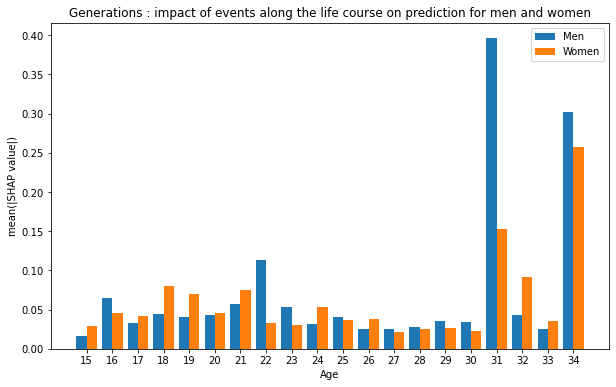

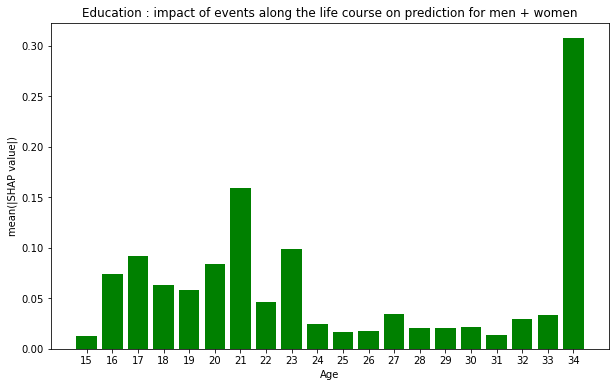

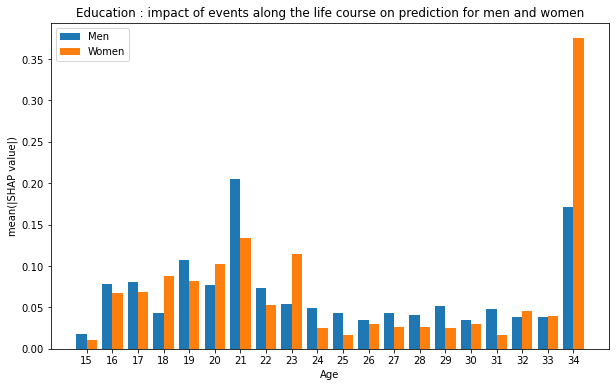

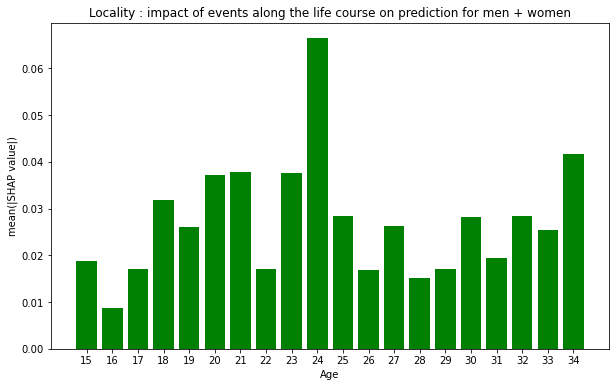

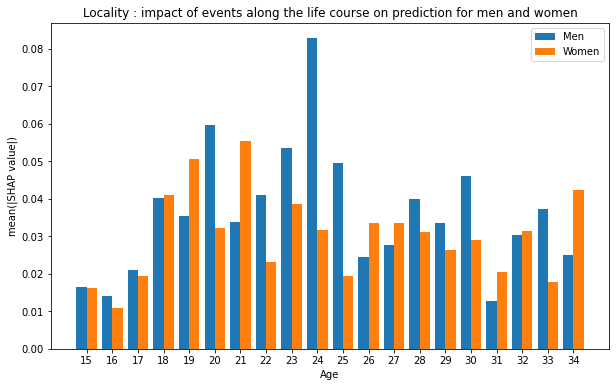

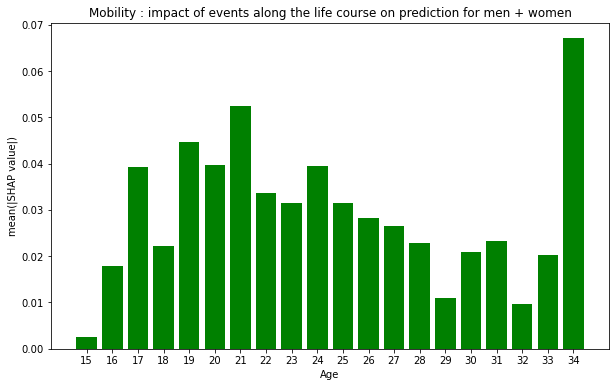

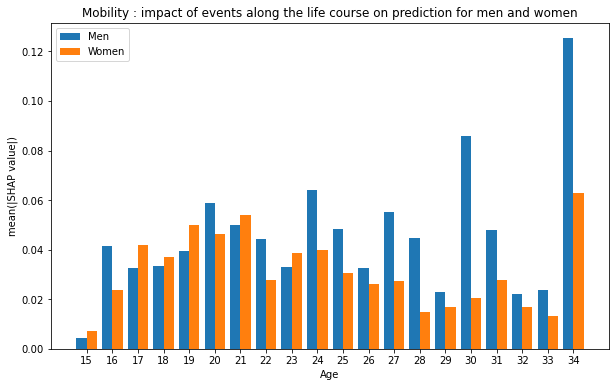

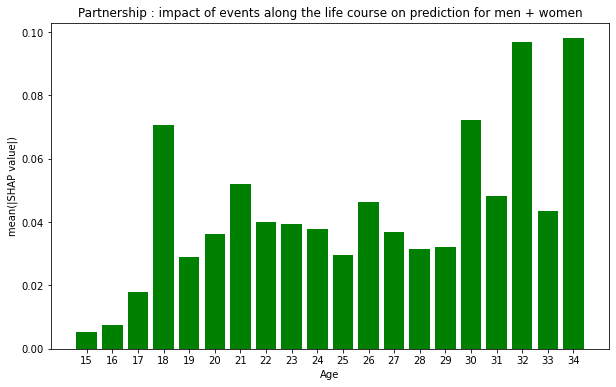

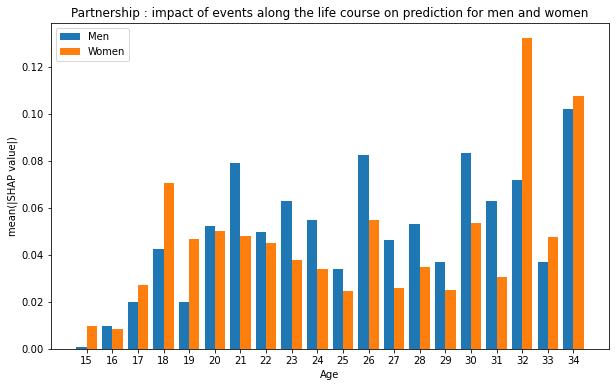

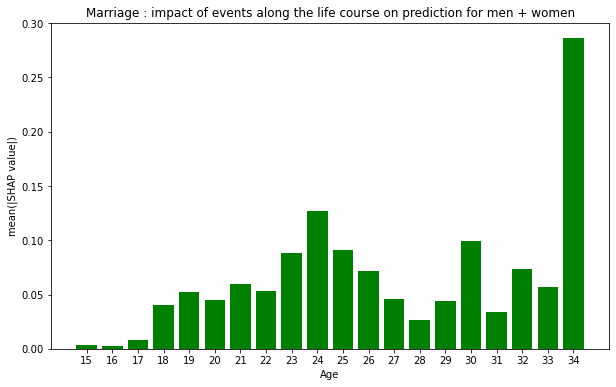

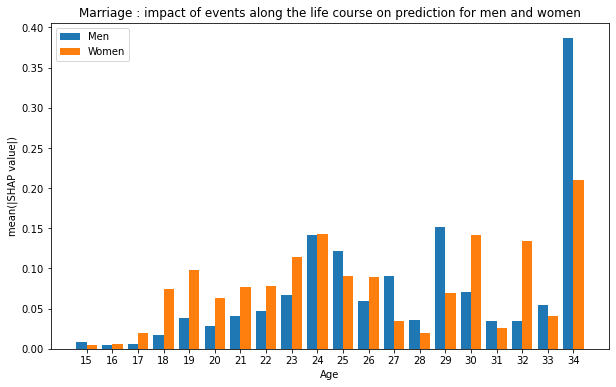

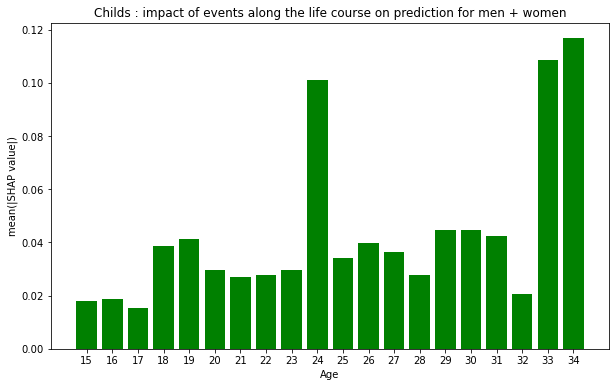

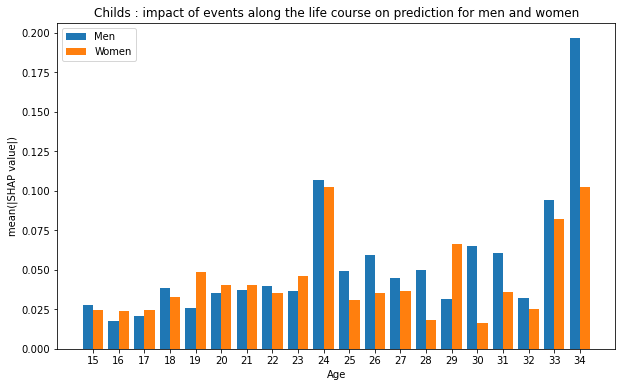

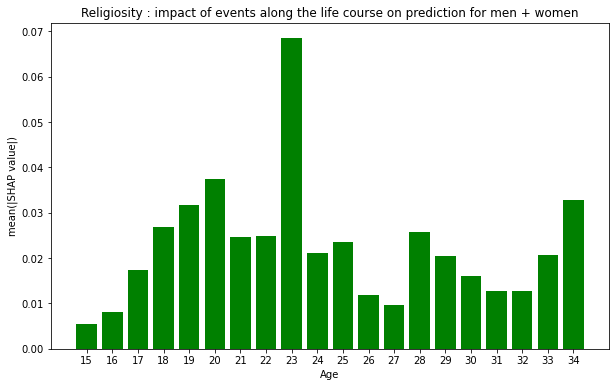

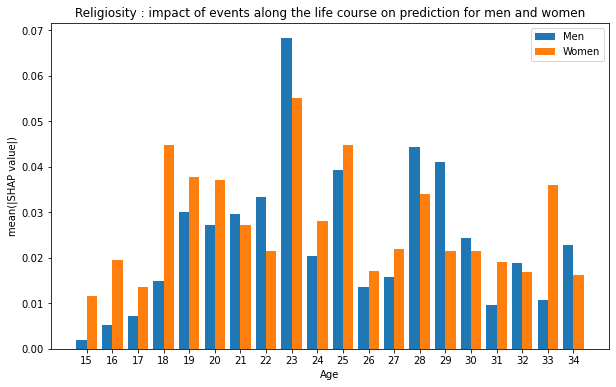

In [1]:
import time
import numpy as np
import pandas as pd
import shap
import copy
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

shap.initjs()

start_time = time.time()

df = pd.read_csv("GGS_new_renamed_features.csv", sep=',')
display(df)
df=shuffle(df, random_state=7)

df[["Religiosity","Religion","Church_visit"]] = (df[["Religiosity","Religion","Church_visit"]]+1).fillna(0).astype('int32')
df["Generation_bin"] = df["Generations"].map({1:1, 2:1, 3:1, 4:1, 5:2, 6:2})
df = df.fillna("Data_missing")
#display(df)


features = ["Gender","Generation_bin","Generations","Education","Locality","Mobility","Partnership",
            "Marriage","Childs","Religiosity"]


models = [#["SVM     ", svm.SVC(probability=False, gamma='auto')],
          ["XGBoost ", XGBClassifier(n_estimators=500, learning_rate=0.01, verbosity=0)]]
          #["CatBoost", CatBoostClassifier(iterations=700, learning_rate=0.01, verbose=False)]]

years = []
for year in range(15, 35):
    years.append('a' + str(year) + '.6')

#import random
#random.shuffle(years)
#print(years)

XS = df[years]
XSw = df[df['Gender'] == 2][years]
XSm = df[df['Gender'] == 1][years]
#display(XS)

print("\nMen:\t", XSm.shape[0])
print("Women:\t", XSw.shape[0])
print("Total:\t", XS.shape[0])

print("================================ SHAP ==================================")


XF = df[features]

df_shap_f = pd.DataFrame(columns=features)

for y_status in XS.columns: 
    #print('y_status:', y_status)
    model_f = copy.deepcopy(models[0][1])    
    model_f.fit(XF, XS[y_status])
    explainer_f = shap.Explainer(model_f)
    shap_values_f = explainer_f(XF)
         
    for j in range(shap_values_f.shape[1]):            
        for i in range(shap_values_f.shape[0]):
            shap_values_f.values[i, j, 0] = np.mean(abs(shap_values_f.values[i, j, :]))
                
    shap.plots.bar(shap_values_f[:, :, 0], max_display=20, show=False)    
    ax_f = plt.gca()
    
    if y_status == "a34.6":
        print("\n\t\tFeatures impact on status prediction for Age=34")
        plt.show()
    else:
        plt.close()
        
    labels_f = [l.get_text() for l in ax_f.get_yticklabels()][:10]
    values_f = [rect.get_width() for rect in ax_f.patches][:10]
    
    df_shap_f_a = pd.DataFrame([values_f], columns=labels_f)    
    df_shap_f = df_shap_f.append(df_shap_f_a, ignore_index=True)
    

    
df_shap_f["Age"] = np.arange(15, 15 + df_shap_f.shape[0])
#display(df_shap_f)

df_shap_f.plot(x="Age", xticks=range(15, 35, 1), ylabel="mean(|SHAP value|)", figsize=(10, 6)) 
              #title="Features impact along the life course on status prediction")
print("Features impact along the life course on status prediction")
plt.show()


for feature in features:
    
    y = df[feature]

    XS = XS.apply(LabelEncoder().fit_transform).copy()    
    XS_train, XS_test, yS_train, yS_test = train_test_split(XS, y, test_size=0.2, random_state=42)
    
    yw = df[df['Gender'] == 2][feature]    # for women
    XSw = XSw.apply(LabelEncoder().fit_transform).copy()    
    
    ym = df[df['Gender'] == 1][feature]      # for men
    XSm = XSm.apply(LabelEncoder().fit_transform).copy()    
    
    
    #print("\n", feature, ": impact of events on prediction along the life course")
    #print("______________________________________________________________________\n")
    
    for model in models:
        
        model_w = copy.deepcopy(model[1])
        model_m = copy.deepcopy(model[1])
        model_s = copy.deepcopy(model[1])
        
        #model[1].fit(XS_train, yS_train)
        #yS_pred = model[1].predict(XS_test)
        
        model[1].fit(XS, y)
        model_w.fit(XSw, yw)
        model_m.fit(XSm, ym)
        
        
        ###explainer = shap.TreeExplainer(model[1], XS)
        ###explainer = shap.TreeExplainer(model[1])
        
        explainer = shap.Explainer(model[1])
        shap_values = explainer(XS)
        #print(shap_values.shape)
        
        explainer_w = shap.Explainer(model_w)
        shap_values_w = explainer_w(XSw)
        #print(shap_values_w.shape)
        
        explainer_m = shap.Explainer(model_m)
        shap_values_m = explainer_m(XSm)
        #print(shap_values_m.shape)
        
        #print(shap_values)
        
        #gender = ["Women" if shap_values[i,"Gender"].data == 0 else "Men" for i in range(shap_values.shape[0])]
        #shap.plots.bar(shap_values.cohorts(gender).abs.mean(0))
        
        if len(shap_values.shape) <= 2:
            shap.plots.bar(shap_values, max_display=20, show=False)
            ax = plt.gca()
            plt.close()
            if feature != "Gender":
                shap.plots.bar(shap_values_w, max_display=20, show=False)
                ax_w = plt.gca()
                plt.close()
                shap.plots.bar(shap_values_m, max_display=20, show=False)
                ax_m = plt.gca()
                plt.close()
            
        else:   # for multiclass ( >2 ) feature
            for j in range(shap_values.shape[1]):
                for i in range(shap_values.shape[0]):
                    shap_values.values[i, j, 0] = np.mean(abs(shap_values.values[i, j, :]))
                    
                for i in range(shap_values_w.shape[0]):
                    shap_values_w.values[i, j, 0] = np.mean(abs(shap_values_w.values[i, j, :]))
                    
                for i in range(shap_values_m.shape[0]):
                    shap_values_m.values[i, j, 0] = np.mean(abs(shap_values_m.values[i, j, :]))
                
            shap.plots.bar(shap_values[:, :, 0], max_display=20, show=False)
            ax = plt.gca()
            plt.close()
            shap.plots.bar(shap_values_w[:, :, 0], max_display=20, show=False)
            ax_w = plt.gca()
            plt.close()
            shap.plots.bar(shap_values_m[:, :, 0], max_display=20, show=False)
            ax_m = plt.gca()
            plt.close()
        
        
        labels = [l.get_text()[1:3] for l in ax.get_yticklabels()][:20]
        values = [rect.get_width() for rect in ax.patches][:20] 
        df_shap = pd.DataFrame({'Labels': labels, 'Values': values})
        df_shap.sort_values(by=['Labels'], ascending=True, inplace=True)
        #plt.show()

        fig, ay = plt.subplots()
        ay.set_ylabel('mean(|SHAP value|)')
        ay.set_xlabel('Age')
        #ay.set_title(feature + ' : impact of events along the life course on prediction for men + women')
        ay.bar(df_shap['Labels'], df_shap['Values'], color='green')        
        fig.set_size_inches(10, 6)
        print('Impact of statuses along the life path on', feature, 'prediction for men + women')
        plt.show()
        
        
        if feature != "Gender":
            
            labels_w = [l.get_text()[1:3] for l in ax_w.get_yticklabels()][:20]
            values_w = [rect.get_width() for rect in ax_w.patches][:20]
            df_shap_w = pd.DataFrame({'Labels': labels_w, 'Values': values_w})
            df_shap_w.sort_values(by=['Labels'], ascending=True, inplace=True)


            labels_m = [l.get_text()[1:3] for l in ax_m.get_yticklabels()][:20]
            values_m = [rect.get_width() for rect in ax_m.patches][:20]
            df_shap_m = pd.DataFrame({'Labels': labels_m, 'Values': values_m})
            df_shap_m.sort_values(by=['Labels'], ascending=True, inplace=True)
            
            plt.show()
            
            x = np.arange(15, 35)  # the label locations
            width = 0.40  # the width of the bars
            
            fig, ay = plt.subplots()
            rects_m = ay.bar(x - width/2, df_shap_m['Values'], width, label='Men')
            rects_w = ay.bar(x + width/2, df_shap_w['Values'], width, label='Women')
            
            ay.set_ylabel('mean(|SHAP value|)')
            ay.set_xlabel('Age')
            #ay.set_title(feature + ' : impact of events along the life course on prediction for men and women')
            ay.set_xticks(range(15, 35, 1))
            ay.legend()
            fig.set_size_inches(10, 6)
            print("Impact of statuses along life path on", feature, "prediction.")
            plt.show()

